## FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train, fcn_coco_train, prep_coco_dataset
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

Using TensorFlow backend.


 Linx  Linux
Tensorflow Version: 1.8.0   Keras Version : 2.1.6 


## Notebook Preferences

In [49]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# def display_weight_histograms(model):
#     LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
#     # Get layers
#     layers = model.get_trainable_layers()
#     layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, layers))
#     # Display Histograms
#     fig, ax = plt.subplots(len(layers), 2, 
#                            figsize=(24, 4*len(layers)),
#                            gridspec_kw={"hspace":1})
#     for l, layer in enumerate(layers):
#         weights = layer.get_weights()
#         for w, weight in enumerate(weights):
#             tensor = layer.weights[w]
#             ax[l, w].set_title(tensor.name)
#             _ = ax[l, w].hist(weight[w].flatten(), 75)
# 
    

## Configurations

In [10]:
DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
DIR_WEIGHTS = '/home/kbardool/models/train_fcn_coco/fcn20181023T0825'
files = ['fcn_0001.h5','fcn_0002.h5','fcn_0003.h5']
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH    = FCN_TRAINING_PATH

fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.WEIGHT_DECAY         = 2.0e-4
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'

fcn_config.display()


Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL

## Load Model

In [11]:
with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN32', config=fcn_config)

>>> Initialize ModelBase model 
   Mode      :  training
   Model dir :  /home/kbardool/models/train_fcn_coco
>>> ModelBase initialiation complete
>>> Initialize FCN model, mode:  training architecture:  FCN32
NewFolder: False  config.NEW_LOG_FOLDER: True 
  set_log_dir(): self.Checkpoint_path: /home/kbardool/models/train_fcn_coco/fcn20181023T1502/fcn_{epoch:04d}.h5 
  set_log_dir(): self.log_dir        : /home/kbardool/models/train_fcn_coco/fcn20181023T1502 
  set_log_dir(): Last completed epoch (self.epoch): 0 
arch set to FCN32
<function fcn32_graph at 0x7f4aac052378>


---------------------------------------------------
   Arch:  FCN32  Adding  FCN layers
---------------------------------------------------

>>> FCN Layer 
     feature map      : (?, 256, 256, 81)
     height : 256 width : 256 classes : 81
     image_data_format:  channels_last
     rois_per_class   :  channels_last
   FCN Block 11 shape is :  (?, 256, 256, 64)
   FCN Block 12 shape is :  (?, 256, 256, 64)
   FCN Bl

In [54]:
fcn_model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_pr_hm_norm (InputLayer)   (None, 256, 256, 81) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 46720       input_pr_hm_norm[0][0]           
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

## Load Weights - 1

In [23]:
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181020T1506/fcn_0124.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181021T1602/fcn_0188.h5'
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181022T1622/fcn_0001.h5'

weights_path = os.path.join(DIR_WEIGHTS  , files[1])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0001.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0001.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0001.h5
 List Model layers and matching hd5 layers, if present :     
    0  input_pr_hm_norm..............  1 
    1  block1_conv1..................  1 
    2  block1_conv2..................  1 
    3  block1_pool...................  1 
    4  block2_conv1..................  1 
    5  block2_conv2..................  1 
    6  block2_pool...................  1 
    7  block3_conv1..................  1 
    8  block3_conv2..................  1 
    9  block3_conv3..................  1 
   10  block3_pool...................  1 
   11  block4_conv1..................  1 
   12  block4_conv2.................. 


 19 fc1                       Model Layer Name/Type : [('fc1', <keras.layers.convolutional.Conv2D object at 0x7f4aa79387f0>)] 
                              Weights     : ['fc1/kernel:0', 'fc1/bias:0']
                               Symbolic Weights from Model
                                0 (7, 7, 512, 4096)  
                                1 (4096,)  
                               len weight_values: 2   len symbolic_weights: 2
                               i: 0  hdf5 weight shape: (7, 7, 512, 4096)   symb wgt shp: (7, 7, 512, 4096)
                                0 fc1/kernel:0                         hdf5 Weights: (7, 7, 512, 4096)  Symbolic Wghts: (7, 7, 512, 4096)
                               i: 1  hdf5 weight shape: (4096,)   symb wgt shp: (4096,)
                                1 fc1/bias:0                           hdf5 Weights: (4096,)  Symbolic Wghts: (4096,)

 20 dropout_1                 Model Layer Name/Type : [('dropout_1', <keras.layers.core.Dropout object at 0x7

### Review Weight Stats - 1st weight file

In [24]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
block1_conv1/kernel:0,"(3, 3, 81, 64)",-0.0678050,+0.0677980,+0.0391160
block1_conv1/bias:0,"(64,)",+0.0000000,+0.0000000,+0.0000000
block1_conv2/kernel:0,"(3, 3, 64, 64)",-0.0721641,+0.0721622,+0.0417119
block1_conv2/bias:0,"(64,)",+0.0000000,+0.0000000,+0.0000000
block2_conv1/kernel:0,"(3, 3, 64, 128)",-0.0589248,+0.0589247,+0.0339594
block2_conv1/bias:0,"(128,)",+0.0000000,+0.0000000,+0.0000000
block2_conv2/kernel:0,"(3, 3, 128, 128)",-0.0510309,+0.0510298,+0.0294541
block2_conv2/bias:0,"(128,)",+0.0000000,+0.0000000,+0.0000000
block3_conv1/kernel:0,"(3, 3, 128, 256)",-0.0416666,+0.0416666,+0.0240691
block3_conv1/bias:0,"(256,)",+0.0000000,+0.0000000,+0.0000000


### Histograms of Weights

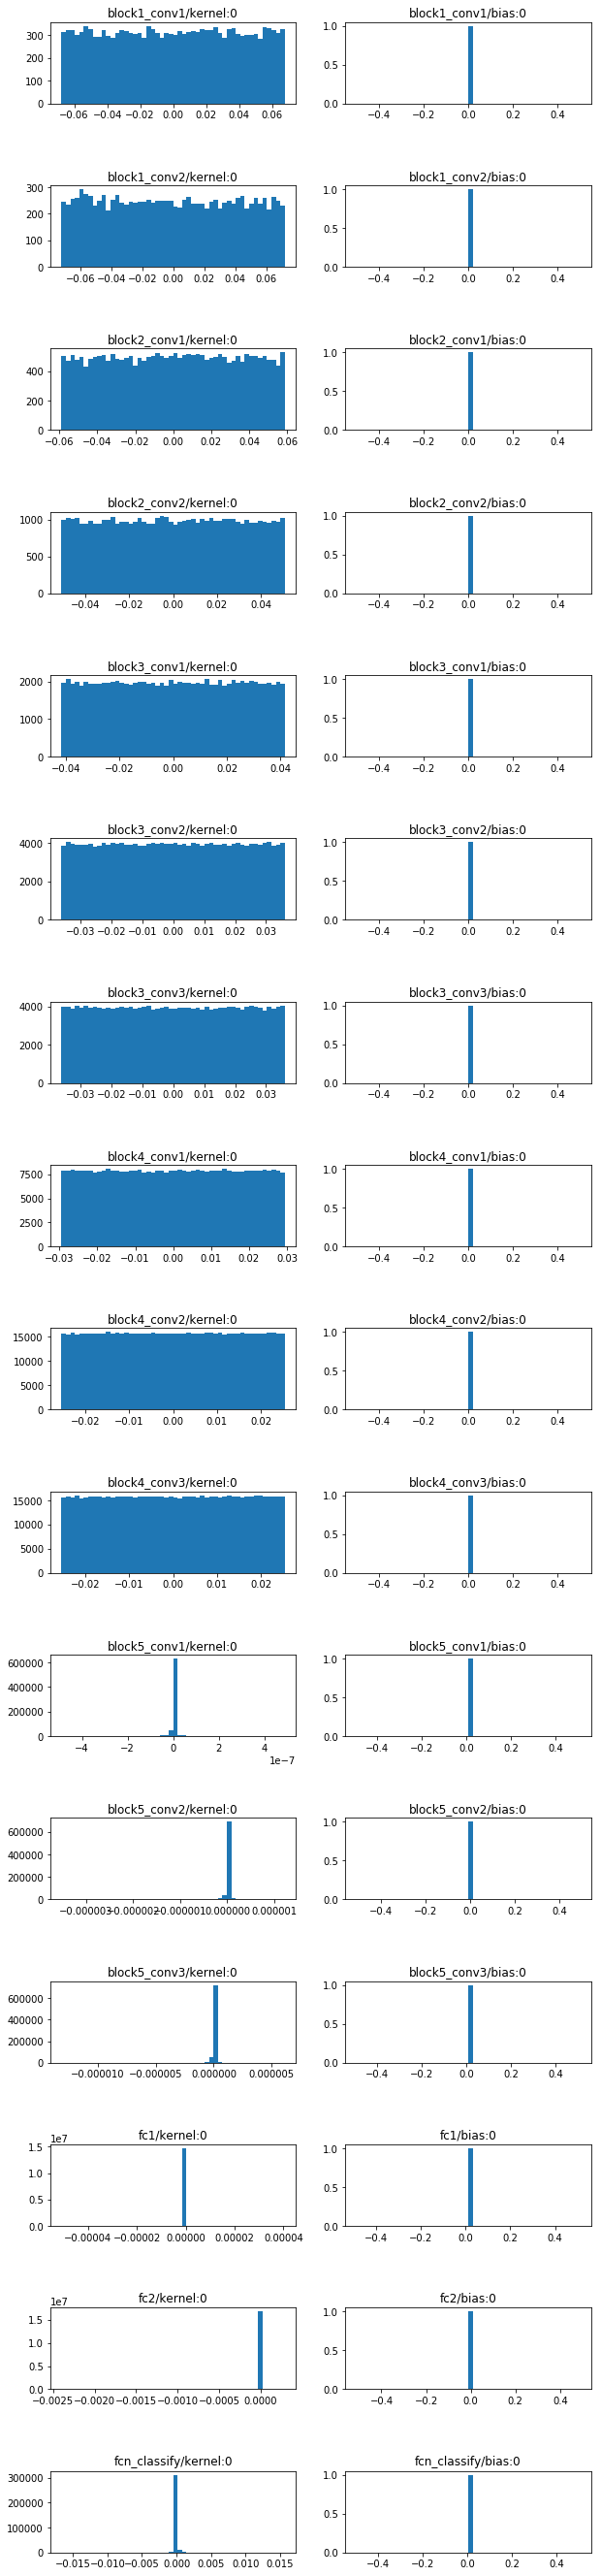

In [53]:
# Pick layer types to display
visualize.display_weight_histograms(fcn_model)

## Load Weights - 2

In [25]:
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181020T1200/fcn_0045.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181021T1602/fcn_0188.h5'
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181022T1622/fcn_0002.h5'
# Set weights file path or uncomment to load the last model you trained
# weights_path = model.find_last()[1]

weights_path = os.path.join(DIR_WEIGHTS  , files[2])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0002.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0002.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0002.h5
 List Model layers and matching hd5 layers, if present :     
    0  input_pr_hm_norm..............  1 
    1  block1_conv1..................  1 
    2  block1_conv2..................  1 
    3  block1_pool...................  1 
    4  block2_conv1..................  1 
    5  block2_conv2..................  1 
    6  block2_pool...................  1 
    7  block3_conv1..................  1 
    8  block3_conv2..................  1 
    9  block3_conv3..................  1 
   10  block3_pool...................  1 
   11  block4_conv1..................  1 
   12  block4_conv2.................. 


 21 fc2                       Model Layer Name/Type : [('fc2', <keras.layers.convolutional.Conv2D object at 0x7f4aa7938a90>)] 
                              Weights     : ['fc2/kernel:0', 'fc2/bias:0']
                               Symbolic Weights from Model
                                0 (1, 1, 4096, 4096)  
                                1 (4096,)  
                               len weight_values: 2   len symbolic_weights: 2
                               i: 0  hdf5 weight shape: (1, 1, 4096, 4096)   symb wgt shp: (1, 1, 4096, 4096)
                                0 fc2/kernel:0                         hdf5 Weights: (1, 1, 4096, 4096)  Symbolic Wghts: (1, 1, 4096, 4096)
                               i: 1  hdf5 weight shape: (4096,)   symb wgt shp: (4096,)
                                1 fc2/bias:0                           hdf5 Weights: (4096,)  Symbolic Wghts: (4096,)

 22 dropout_2                 Model Layer Name/Type : [('dropout_2', <keras.layers.core.Dropout object a

### Review Weight Stats - 2nd weights file

In [26]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
block1_conv1/kernel:0,"(3, 3, 81, 64)",-0.0678050,+0.0677980,+0.0391160
block1_conv1/bias:0,"(64,)",+0.0000000,+0.0000000,+0.0000000
block1_conv2/kernel:0,"(3, 3, 64, 64)",-0.0721641,+0.0721622,+0.0417119
block1_conv2/bias:0,"(64,)",+0.0000000,+0.0000000,+0.0000000
block2_conv1/kernel:0,"(3, 3, 64, 128)",-0.0589248,+0.0589247,+0.0339594
block2_conv1/bias:0,"(128,)",+0.0000000,+0.0000000,+0.0000000
block2_conv2/kernel:0,"(3, 3, 128, 128)",-0.0510309,+0.0510298,+0.0294541
block2_conv2/bias:0,"(128,)",+0.0000000,+0.0000000,+0.0000000
block3_conv1/kernel:0,"(3, 3, 128, 256)",-0.0416666,+0.0416666,+0.0240691
block3_conv1/bias:0,"(256,)",+0.0000000,+0.0000000,+0.0000000


### Histograms of Weights

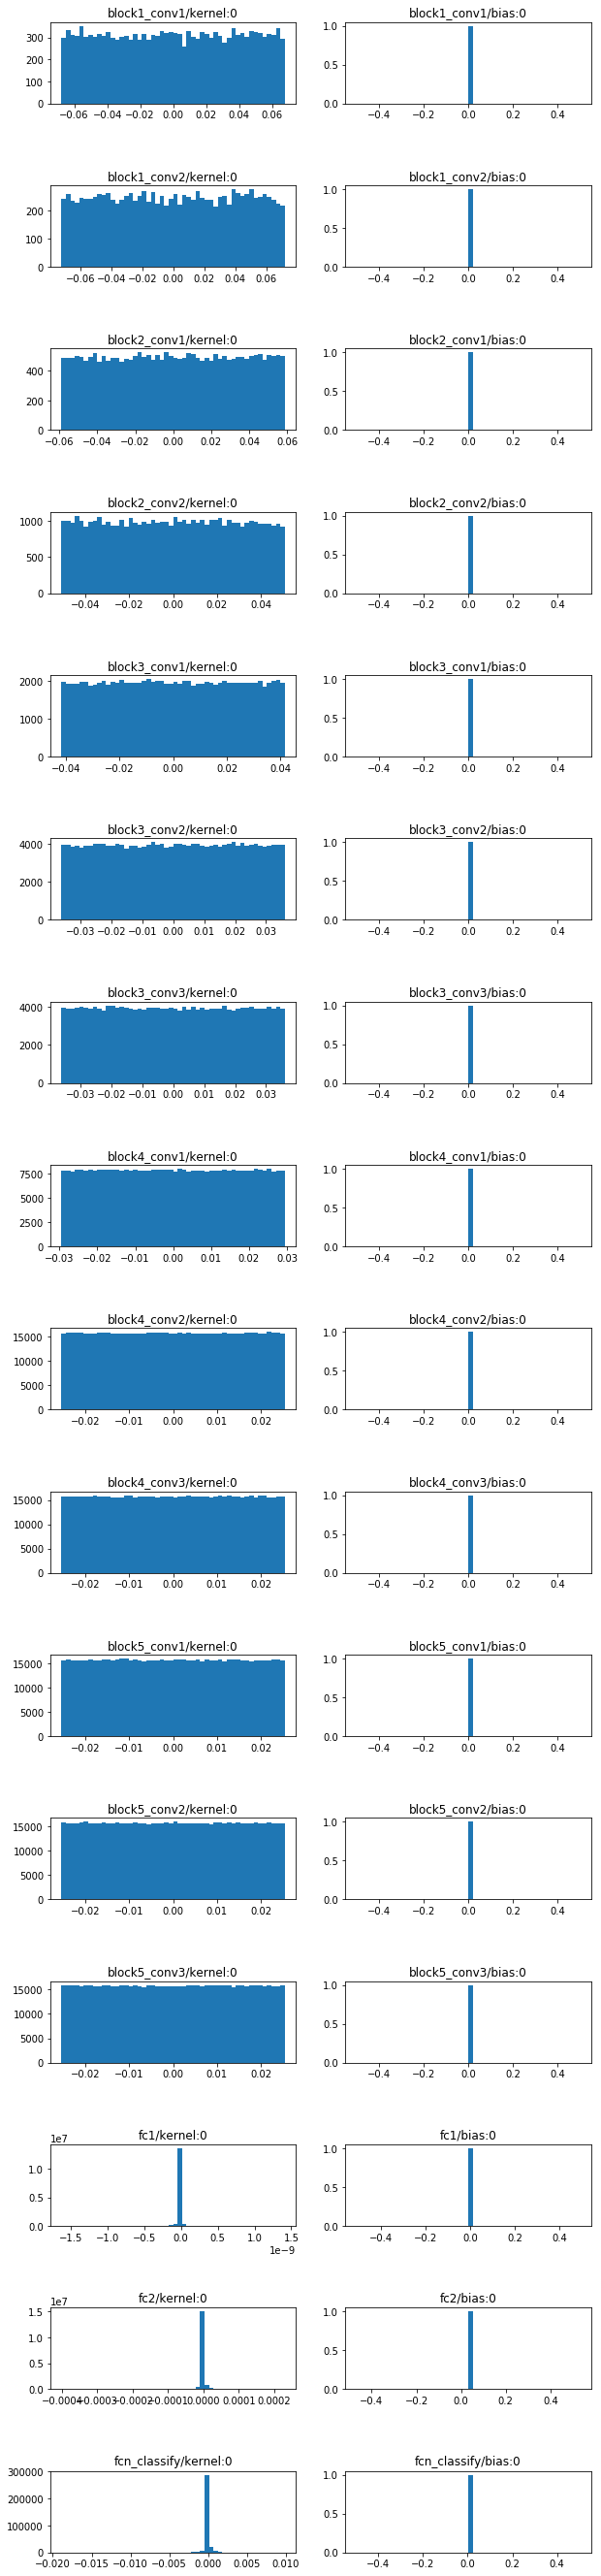

In [18]:
visualize.display_weight_histograms(fcn_model)

## Load Weights - 3rd weight file

In [27]:
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181020T1506/fcn_0124.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181021T1602/fcn_0188.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181022T1415/fcn_0004.h5'
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181022T1622/fcn_0003.h5'

weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0003.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0003.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn_coco/fcn20181023T0825/fcn_0003.h5
 List Model layers and matching hd5 layers, if present :     
    0  input_pr_hm_norm..............  1 
    1  block1_conv1..................  1 
    2  block1_conv2..................  1 
    3  block1_pool...................  1 
    4  block2_conv1..................  1 
    5  block2_conv2..................  1 
    6  block2_pool...................  1 
    7  block3_conv1..................  1 
    8  block3_conv2..................  1 
    9  block3_conv3..................  1 
   10  block3_pool...................  1 
   11  block4_conv1..................  1 
   12  block4_conv2.................. 

                                0 fc1/kernel:0                         hdf5 Weights: (7, 7, 512, 4096)  Symbolic Wghts: (7, 7, 512, 4096)
                               i: 1  hdf5 weight shape: (4096,)   symb wgt shp: (4096,)
                                1 fc1/bias:0                           hdf5 Weights: (4096,)  Symbolic Wghts: (4096,)

 20 dropout_1                 Model Layer Name/Type : [('dropout_1', <keras.layers.core.Dropout object at 0x7f4aa7938a58>)] 
                              Weights     : []
                               Symbolic Weights from Model
                               len weight_values: 0   len symbolic_weights: 0

 21 fc2                       Model Layer Name/Type : [('fc2', <keras.layers.convolutional.Conv2D object at 0x7f4aa7938a90>)] 
                              Weights     : ['fc2/kernel:0', 'fc2/bias:0']
                               Symbolic Weights from Model
                                0 (1, 1, 4096, 4096)  
                             

### Review Weight Stats - 3rd weight file

In [51]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
block1_conv1/kernel:0,"(3, 3, 81, 64)",-0.0678050,+0.0677980,+0.0391160
block1_conv1/bias:0,"(64,)",+0.0000000,+0.0000000,+0.0000000
block1_conv2/kernel:0,"(3, 3, 64, 64)",-0.0721641,+0.0721622,+0.0417119
block1_conv2/bias:0,"(64,)",+0.0000000,+0.0000000,+0.0000000
block2_conv1/kernel:0,"(3, 3, 64, 128)",-0.0589248,+0.0589247,+0.0339594
block2_conv1/bias:0,"(128,)",+0.0000000,+0.0000000,+0.0000000
block2_conv2/kernel:0,"(3, 3, 128, 128)",-0.0510309,+0.0510298,+0.0294541
block2_conv2/bias:0,"(128,)",+0.0000000,+0.0000000,+0.0000000
block3_conv1/kernel:0,"(3, 3, 128, 256)",-0.0416666,+0.0416666,+0.0240691
block3_conv1/bias:0,"(256,)",+0.0000000,+0.0000000,+0.0000000


## Histograms of Weights

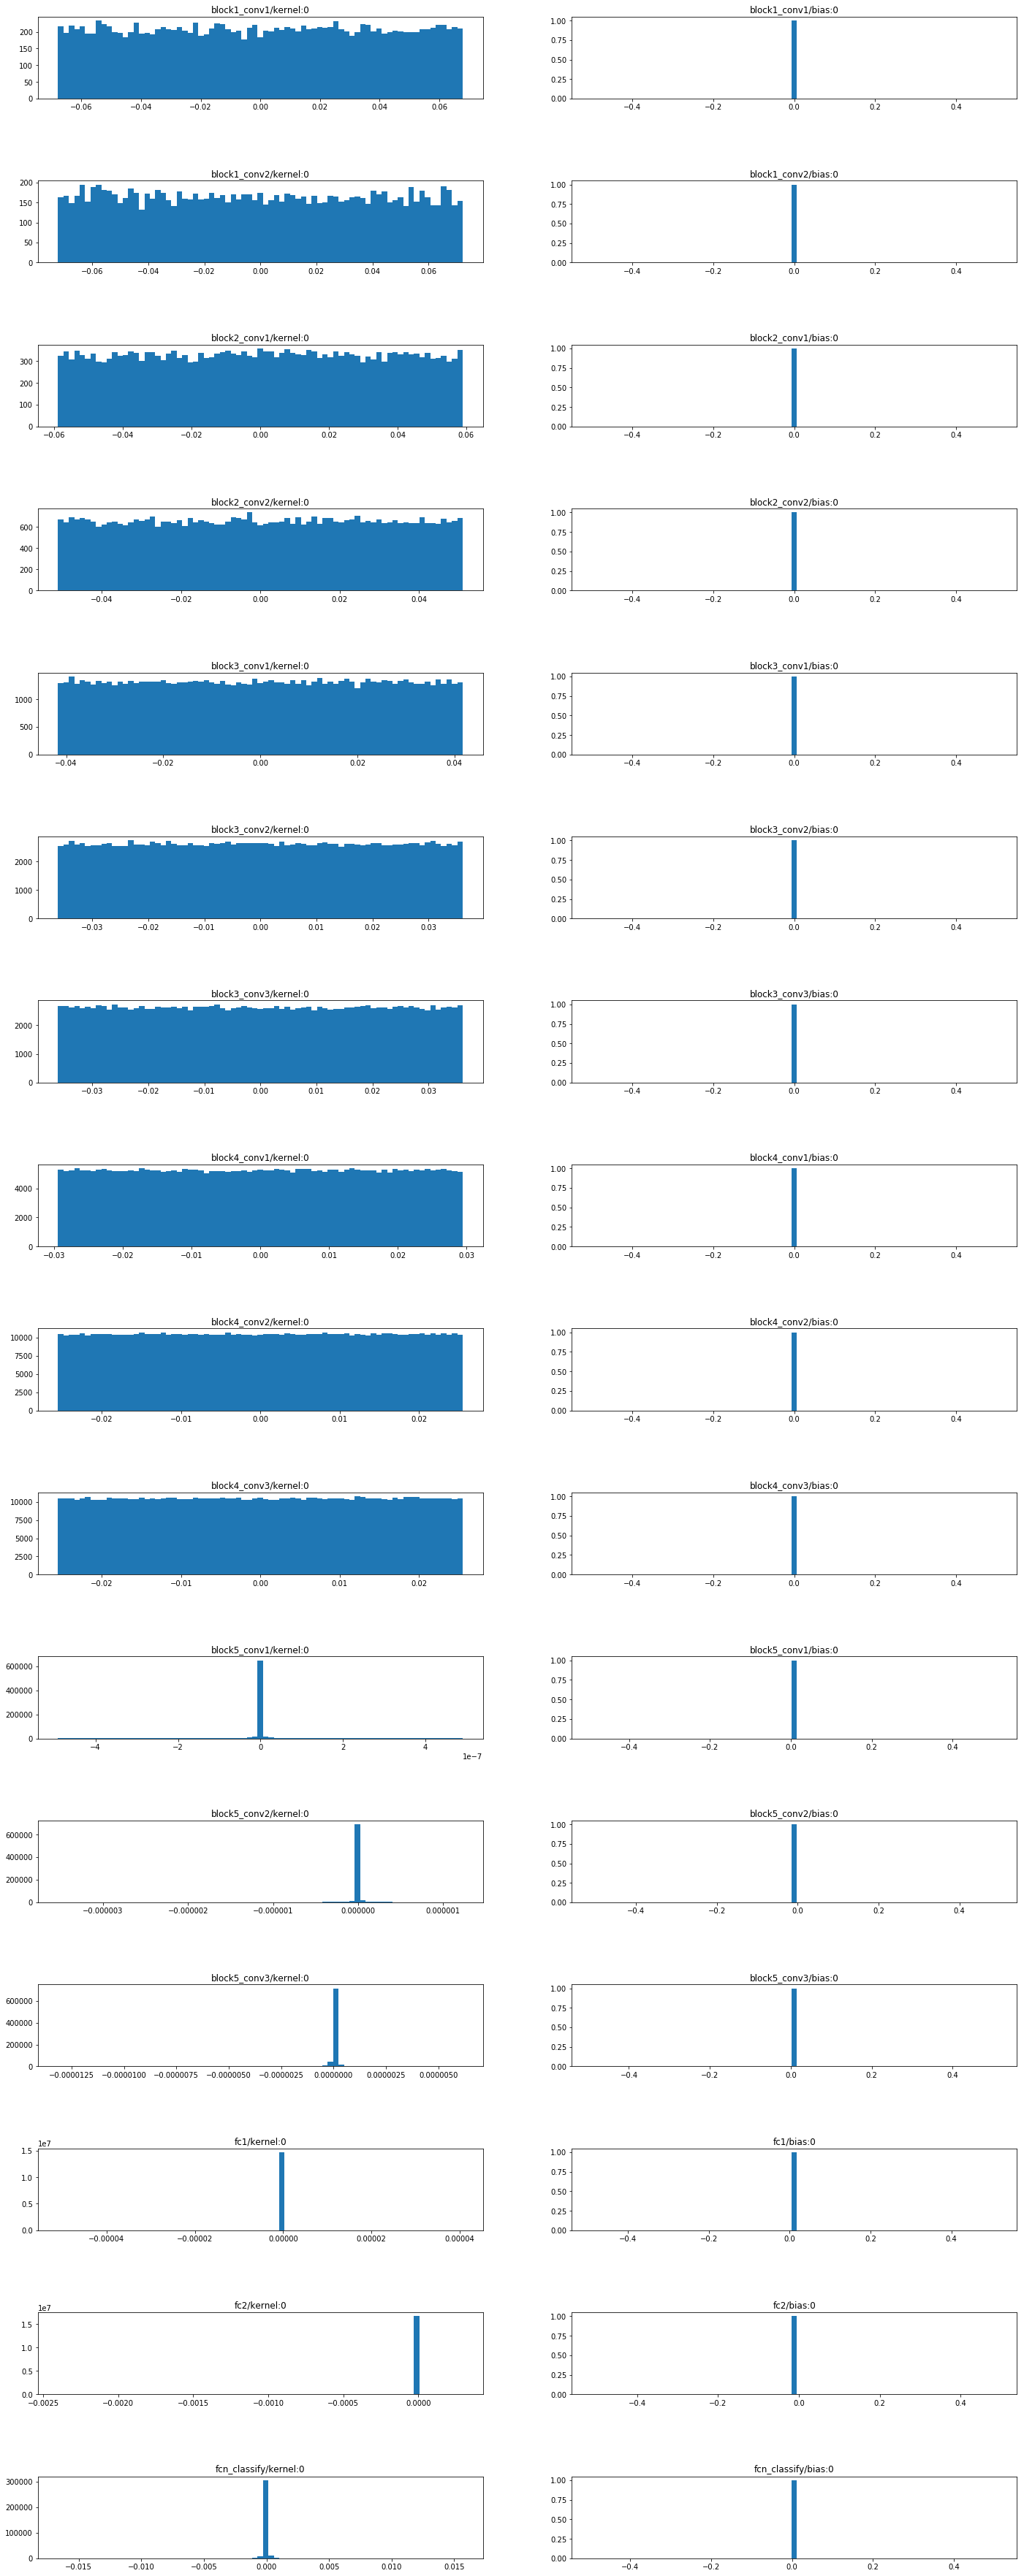

In [52]:
visualize.display_weight_histograms(fcn_model)

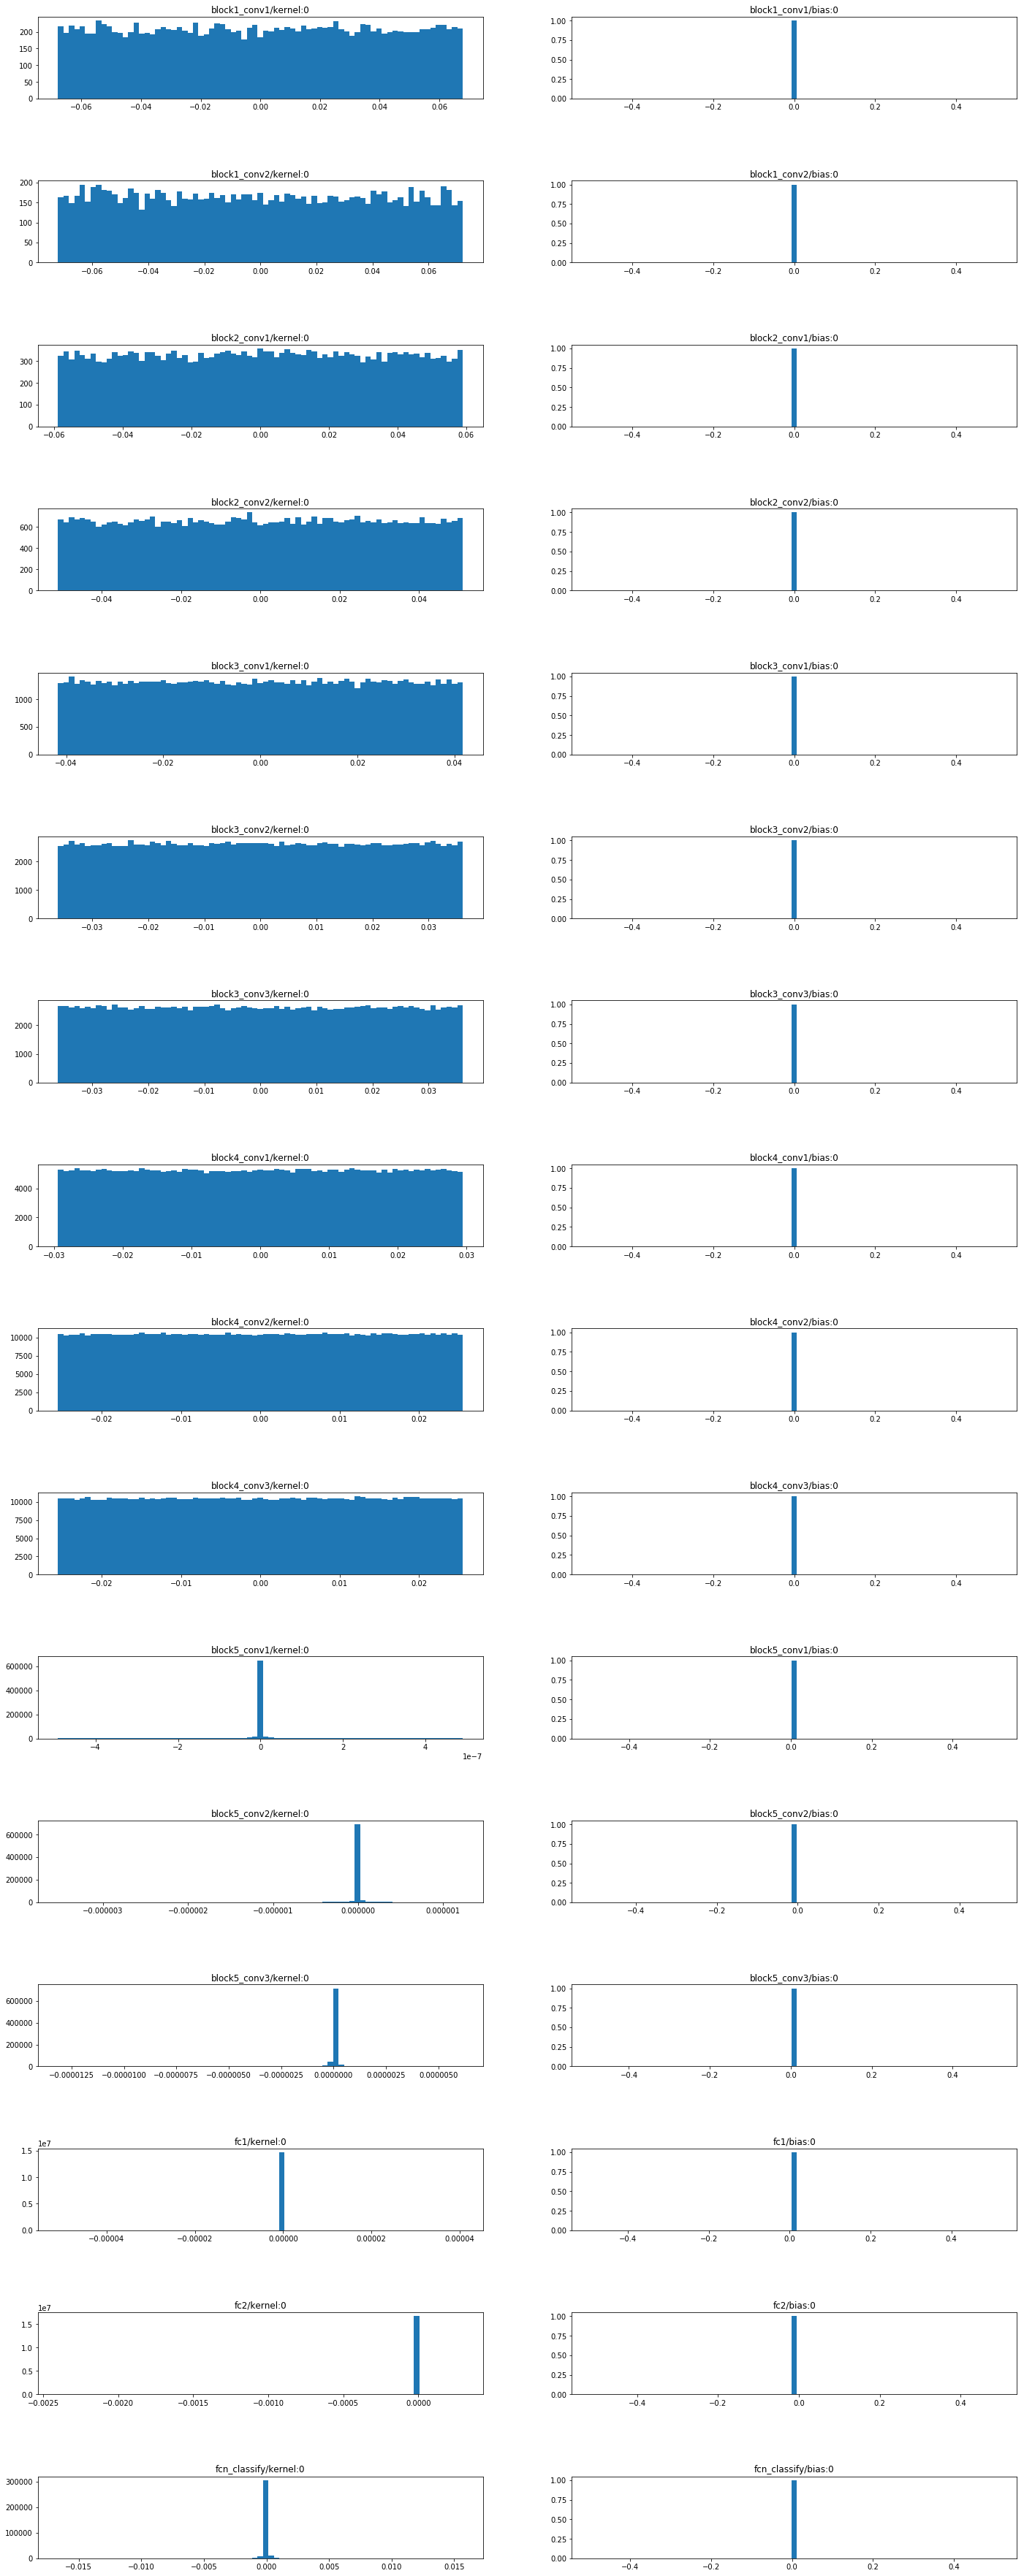

In [50]:
visualize.display_weight_histograms(fcn_model)